# Data scrapping from the Web

In this notebook, we scrape the plot summaries and the box office revenue information from Wikipedia. 

Approximately 40% of film summaries and over 90% of box office values are missing, and these metrics are essential for our analysis. 

To fill these gaps, we use libraries like wikipedia-api and pywikibot, and in cases requiring more detail, we utilize requests and BeautifulSoup for web scraping. Our approach involves extracting summaries from the Plot/Synopsis/Summary sections and box office revenue from the InfoBox, ensuring we access the correct page by handling title variations, such as adding "(film), and handling page redirections.

This process enriches our data, specifically targeting films with incomplete summaries (replacing those under 200 words with the Wikipedia entry) and adding missing box office values.

In [1]:
!pip3 install wikipedia-api pandas pywikibot requests 



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\inesa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import json
import wikipediaapi
import pywikibot
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

In [27]:
DATA_PATH = "../../../data/our_movie_data.csv"
pd.set_option("max_colwidth", None)

In [28]:
df_movie = pd.read_csv(DATA_PATH)
df_movie_unscraped = df_movie.copy()

In [29]:
# Initialize a Wikipedia object using the wikipedia-api library, specifying the English language
wiki_object = wikipediaapi.Wikipedia('MovieSummaryExtractor', 'en')

# Initialize a pywikibot Site object for interacting with the English Wikipedia
site = pywikibot.Site("en", "wikipedia")

Functions to verify that the Wikipedia page is a valid film page

In [30]:
def has_film_section(film_name):
    """
    Check if a Wikipedia page has a film-related section.
    Returns True if any of Plot/Summary/Synopsis sections exist.
    """
    try:
        page_py = wiki_object.page(film_name)
        if not page_py.exists():
            return False
            
        # Try to find the plot, summary, or synopsis section
        for section_title in ["Plot", "Summary", "Synopsis"]:
            try:
                section_plot = page_py.section_by_title(section_title)
                if section_plot:  
                    return True
            except Exception as e:
                print(f"Error checking section {section_title} for {film_name}: {str(e)}")
                continue
                
        return False
        
    except Exception as e:
        print(f"Error in has_film_section for {film_name}: {str(e)}")
        return False

def is_film_Wiki_page(title):
    """
    Verify if a Wikipedia page is film-related and return the correct title.
    Returns: (bool, str) - (is_valid, final_title)
    """
    try:
        # Try original title first
        page = pywikibot.Page(site, title)
        
        # Handle redirects
        if page.exists() and page.isRedirectPage():
            page = page.getRedirectTarget()
            title = page.title()  # Update title to the redirect target
            
        # Check if original title has film sections
        if has_film_section(title):
            return True, title
            
        # If no film sections found, try with "(film)" suffix
        film_title = f"{title} (film)"
        page = pywikibot.Page(site, film_title)
        
        # Handle redirects for "(film)" version
        if page.exists() and page.isRedirectPage():
            page = page.getRedirectTarget()
            film_title = page.title()  # Update to the redirect target
            
        # Check if "(film)" version has film sections
        if has_film_section(film_title):
            return True, film_title
            
        # No valid film page found
        return False, title
        
    except Exception as e:
        print(f"Error in is_film_Wiki_page for {title}: {str(e)}")
        return False, title


Function to extract a Wikipedia summary for a given movie, and update our dataset

In [31]:
def extract_Wiki_summary(movie):
    try:
        # First, check if the movie name is valid
        if pd.isna(movie) or not isinstance(movie, str):
            print(f"Invalid movie name: {movie}")
            return ''
        
        # Check if the Wikipedia page exists and if it's a valid film-related page
        validity, title = is_film_Wiki_page(movie)
        
        if not validity or not title:
            print(f"No valid Wikipedia page found for: {movie}")
            return ''
            
        page_py = wiki_object.page(title)
        if not page_py:
            print(f"Could not fetch Wikipedia page for: {movie}")
            return ''
            
        # Iterate over potential section titles
        for section_title in ["Plot", "Summary", "Synopsis"]:
            try:
                section_plot = page_py.section_by_title(section_title)
                if section_plot and section_plot.text:  
                    cleaned_text = section_plot.text.strip()
                    return cleaned_text if cleaned_text else ''
            except Exception as e:
                print(f"Error extracting {section_title} for {movie}: {str(e)}")
                continue
                
        # If no plot sections found
        print(f"No plot sections found for: {movie}")
        return ''
        
    except Exception as e:
        print(f"Error processing Wikipedia page for {movie}: {str(e)}")
        return ''

In [32]:
def update_summary(row):
    try:
        # First check if the summary is NaN or None
        if pd.isna(row['summary']):
            current_summary = ''
        else:
            # Convert to string, handling potential float values
            current_summary = str(row['summary'])
            # Remove 'nan' or 'None' strings if they exist
            if current_summary.lower() in ['nan', 'none']:
                current_summary = ''

        # Count words in current summary
        word_count = len(current_summary.split())
        
        # Only try to get Wikipedia summary if current summary is too short
        if word_count < 200:
            wikipedia_summary = extract_Wiki_summary(row['Movie_name'])  
            
            if wikipedia_summary:
                wiki_word_count = len(wikipedia_summary.split())
                if wiki_word_count > word_count:
                    return wikipedia_summary
        
        # Return current summary if no better alternative was found
        return current_summary
    
    except Exception as e:
        print(f"Error processing movie: {row['Movie_name']}: {str(e)}")
        return current_summary  # Return whatever we have in case of error

In [33]:
# When applying the function, you might want to add error handling:
try:
    df_movie['summary'] = df_movie.apply(update_summary, axis=1)
except Exception as e:
    print(f"Error updating summaries: {str(e)}")

No valid Wikipedia page found for: Spain in Flames
No valid Wikipedia page found for: Married... with Children
No valid Wikipedia page found for: Manufacturing Consent: Noam Chomsky and the Media
No valid Wikipedia page found for: Patterson-Gimlin film
No valid Wikipedia page found for: Shell Shock
No valid Wikipedia page found for: Star Trek: Deep Space Nine
No valid Wikipedia page found for: Scared to Death
No valid Wikipedia page found for: The Terrorist
No valid Wikipedia page found for: Trekkies
No valid Wikipedia page found for: Waterloo
No valid Wikipedia page found for: The Wizard of Speed and Time
No valid Wikipedia page found for: Developing
No valid Wikipedia page found for: The Phantom Edit
No valid Wikipedia page found for: The Hollywood Revue of 1929
No valid Wikipedia page found for: Animal Crackers
No valid Wikipedia page found for: Perkele
No valid Wikipedia page found for: The Song Remains the Same
No valid Wikipedia page found for: State Fair
No valid Wikipedia page 

Sleeping for 5.0 seconds, 2024-11-23 14:25:00


No valid Wikipedia page found for: Loophole
No valid Wikipedia page found for: The Gnostic
No valid Wikipedia page found for: Never a Dull Moment
No valid Wikipedia page found for: The Split
No valid Wikipedia page found for: Cops and Robbers
No valid Wikipedia page found for: Why Me?
No valid Wikipedia page found for: Rough Cut
No valid Wikipedia page found for: Tuck Everlasting
No valid Wikipedia page found for: Number 13
No valid Wikipedia page found for: The Vagina Dialogues
No valid Wikipedia page found for: Our Wife
No valid Wikipedia page found for: The Evolved
No valid Wikipedia page found for: The Top of His Head
No valid Wikipedia page found for: The One Percent
No valid Wikipedia page found for: Above and Beyond
No valid Wikipedia page found for: Prince Vladimir
No valid Wikipedia page found for: 1 More Hit
No valid Wikipedia page found for: I Trust You To Kill Me
No valid Wikipedia page found for: Karl Liebknecht
No valid Wikipedia page found for: Ziggy Stardust and the Spi

Sleeping for 5.0 seconds, 2024-11-23 14:36:12


No valid Wikipedia page found for: The Ballad of Narayama
No plot sections found for: Face in the Rain
No valid Wikipedia page found for: Loving
No valid Wikipedia page found for: X-Paroni
No valid Wikipedia page found for: Les cabinets de physique : la vie de société au 18e siècle
No valid Wikipedia page found for: Les caractères de La Bruyère
No valid Wikipedia page found for: The Silent Partner
No valid Wikipedia page found for: Lost and Found
No valid Wikipedia page found for: L'enfance d'une ville
No valid Wikipedia page found for: La forme de la ville
No valid Wikipedia page found for: Entretien avec Mallarmé
No valid Wikipedia page found for: Entretien sur Pascal
No valid Wikipedia page found for: Les histoires extraordinaires d'Edgar Poe
No valid Wikipedia page found for: Les jeux de société
No valid Wikipedia page found for: Louis Lumière / conversation avec Langlois et Renoir
No valid Wikipedia page found for: Les métamorphoses du paysage : l'ère industrielle
No valid Wikiped

Sleeping for 5.0 seconds, 2024-11-23 15:05:51


No valid Wikipedia page found for: The Pit and the Pendulum
No valid Wikipedia page found for: Daughter of Darkness
No valid Wikipedia page found for: The Man with No Eyes
No valid Wikipedia page found for: Deep Sea 3D
No valid Wikipedia page found for: 50 Cent: The New Breed
No valid Wikipedia page found for: Boyfriends
No valid Wikipedia page found for: Return Of The Bastards
No valid Wikipedia page found for: Key Party
No valid Wikipedia page found for: Lady Be Good
No valid Wikipedia page found for: American Boyfriends
No plot sections found for: Rehearsal for Murder
No valid Wikipedia page found for: Gospel According to Janis
No valid Wikipedia page found for: Live Free or Die
No valid Wikipedia page found for: Walk the Walk
No valid Wikipedia page found for: Coven
No valid Wikipedia page found for: Dense
No valid Wikipedia page found for: Night-Wolf
No valid Wikipedia page found for: Flash
No valid Wikipedia page found for: Princesa
No valid Wikipedia page found for: Viva Las Lat

Sleeping for 5.0 seconds, 2024-11-23 16:15:37


No valid Wikipedia page found for: Black Gold
No valid Wikipedia page found for: Last Call
No valid Wikipedia page found for: The Search for Signs of Intelligent Life in the Universe
No valid Wikipedia page found for: Animalada
No valid Wikipedia page found for: Years of Revolt
No valid Wikipedia page found for: Coffee and Cigarettes, Memphis Version
No valid Wikipedia page found for: Let's Do It Again
No valid Wikipedia page found for: Hammer
No valid Wikipedia page found for: The Virginian
No valid Wikipedia page found for: The Virginian
No plot sections found for: Girl Without a Room
No valid Wikipedia page found for: Everyday
No valid Wikipedia page found for: Chapayev
No valid Wikipedia page found for: Palomas rubias
No valid Wikipedia page found for: Autocine Mon Amour
No valid Wikipedia page found for: Ayer fue primavera
No valid Wikipedia page found for: Antigua vida mía
No valid Wikipedia page found for: Hurricane!
No valid Wikipedia page found for: Streetwise
No valid Wikiped

Sleeping for 5.0 seconds, 2024-11-23 16:18:43


No valid Wikipedia page found for: The Living Sea
No valid Wikipedia page found for: King Gimp
No valid Wikipedia page found for: Puss in Boots
No valid Wikipedia page found for: Go West
No valid Wikipedia page found for: Real Life Is Elsewhere
No valid Wikipedia page found for: Subhuman
No valid Wikipedia page found for: Aa Gale Lag Jaa
No plot sections found for: Don't Stop Dreaming
No valid Wikipedia page found for: Winning Your Wings
No valid Wikipedia page found for: Love Talk
No valid Wikipedia page found for: It's Everybody's War
No valid Wikipedia page found for: Untitled Bruce McLaren biopic
No valid Wikipedia page found for: Supervising Women Workers
No valid Wikipedia page found for: Chath A Roof Without Walls
No valid Wikipedia page found for: USA vs. Al-Arian
No valid Wikipedia page found for: Coral Reef Adventure
No valid Wikipedia page found for: AFI's 100 Years…100 Movies – 10th Anniversary Edition
No valid Wikipedia page found for: Becoming Royston
No valid Wikipedia p

Sleeping for 5.0 seconds, 2024-11-23 17:21:38
Sleeping for 5.0 seconds, 2024-11-23 17:21:43


No valid Wikipedia page found for: Mahaguru
No valid Wikipedia page found for: John Jani Janardhan
No valid Wikipedia page found for: The Golem
No valid Wikipedia page found for: L'Arroseur
No valid Wikipedia page found for: The Grind
No valid Wikipedia page found for: Crazy House
No valid Wikipedia page found for: A Day Before Tomorrow
No valid Wikipedia page found for: Dirty
No valid Wikipedia page found for: The Adventurers
No valid Wikipedia page found for: España 1936
No valid Wikipedia page found for: We Give Pink Stamps
No valid Wikipedia page found for: The Face on the Bar Room Floor
No valid Wikipedia page found for: Isn't It Romantic?
No valid Wikipedia page found for: Sunset of a Dream
No valid Wikipedia page found for: Words and Music
No valid Wikipedia page found for: Prem Nagar
No valid Wikipedia page found for: Hawas
No valid Wikipedia page found for: Walkin' Free
No valid Wikipedia page found for: Jenin, Jenin


Sleeping for 5.0 seconds, 2024-11-23 17:22:51


No valid Wikipedia page found for: 5 Rifles
No valid Wikipedia page found for: Soorat Aur Seerat
No valid Wikipedia page found for: Begaana
No valid Wikipedia page found for: On the Beach
No valid Wikipedia page found for: El crimen de Cuenca
No valid Wikipedia page found for: Mera Qasoor Kya Hai
No valid Wikipedia page found for: Ganga Ki Lahren
No valid Wikipedia page found for: Mela
No valid Wikipedia page found for: Emmanuelle, Queen of the Galaxy
No valid Wikipedia page found for: Emmanuelle 7: The Meaning of Love
No valid Wikipedia page found for: Emmanuelle 5: A Time to Dream
No valid Wikipedia page found for: Emmanuelle 4: Concealed Fantasy
No valid Wikipedia page found for: Emmanuelle 3: A Lesson in Love
No valid Wikipedia page found for: Emmanuelle: A World of Desire
No valid Wikipedia page found for: Emmanuelle: First Contact
No valid Wikipedia page found for: Cleaver
No valid Wikipedia page found for: Baharon Ki Manzil
No valid Wikipedia page found for: Sonia, Nuvu Na Prema

Sleeping for 5.0 seconds, 2024-11-23 17:40:07
Sleeping for 5.0 seconds, 2024-11-23 17:40:12


No valid Wikipedia page found for: Scales of Justice
No valid Wikipedia page found for: The Dirtwater Dynasty
No valid Wikipedia page found for: The Man Who Invented the Moon
No valid Wikipedia page found for: Ringers: Lord of the Fans
No valid Wikipedia page found for: Ozzfest: 10th Anniversary
No valid Wikipedia page found for: Grateful Dead: Downhill from Here
No valid Wikipedia page found for: Instruction Through Film
No valid Wikipedia page found for: Aaj Ka Laawaris
No valid Wikipedia page found for: The Takeover
No valid Wikipedia page found for: The Miracle Worker
No valid Wikipedia page found for: Welcome to Nollywood
No valid Wikipedia page found for: Daemon
No valid Wikipedia page found for: Isolation
No valid Wikipedia page found for: Oblivion, Nebraska
No valid Wikipedia page found for: Days of Waiting: The Life & Art of Estelle Ishigo
No valid Wikipedia page found for: Arjun Pandit
No valid Wikipedia page found for: Control
No plot sections found for: Creepshow
No valid W

Sleeping for 5.0 seconds, 2024-11-23 18:14:33


No valid Wikipedia page found for: Divorced
No valid Wikipedia page found for: Last Pair Out
No valid Wikipedia page found for: Hi De Ho
No valid Wikipedia page found for: The Song of Life
No valid Wikipedia page found for: The Bride Wore Blood
No valid Wikipedia page found for: Her Summer
No valid Wikipedia page found for: University Heights
No valid Wikipedia page found for: Qafqaz və Merkuri cəmiyyətinin paroxodunun limandan yola düşməsi
No valid Wikipedia page found for: Aviv
No valid Wikipedia page found for: Balaxanı-Sabunçu polis idarəsi süvari qorodovoyların at oynatmaları
No valid Wikipedia page found for: The Oil Gush Fire in Bibiheybat
No valid Wikipedia page found for: One Nine Nine Four
No valid Wikipedia page found for: The Cloth Peddler
No valid Wikipedia page found for: Living Goddess
No valid Wikipedia page found for: Live Facelift
No valid Wikipedia page found for: Farewell Ceremony for His Magesty Emir of Bukhara on "Velikiy Kniaz Alexei" Steamboat
No valid Wikipedia

Sleeping for 5.0 seconds, 2024-11-23 18:17:24


No valid Wikipedia page found for: Before the Fall
No valid Wikipedia page found for: The Jayhawkers!
No valid Wikipedia page found for: Friendly Persuasion
No valid Wikipedia page found for: Stagecoach
No valid Wikipedia page found for: Ayyam al-tawila, al-
No valid Wikipedia page found for: Femmes de Sade
No valid Wikipedia page found for: Maya
No valid Wikipedia page found for: Lonely Street
No valid Wikipedia page found for: Eloise
No valid Wikipedia page found for: Vera
No valid Wikipedia page found for: Frozen
No valid Wikipedia page found for: Jellyfish
No valid Wikipedia page found for: Ishq Ishq
No valid Wikipedia page found for: The Imp
No valid Wikipedia page found for: To the Last Man
No valid Wikipedia page found for: Snow and the Seven
No valid Wikipedia page found for: God Hates Cartoons
No valid Wikipedia page found for: American Mullet
No valid Wikipedia page found for: American Roots Music
No valid Wikipedia page found for: Countryman
No valid Wikipedia page found for

Sleeping for 5.0 seconds, 2024-11-23 18:29:20
Sleeping for 5.0 seconds, 2024-11-23 18:29:25


No plot sections found for: Yes, Yes, Nanette
No valid Wikipedia page found for: They All Fall
No valid Wikipedia page found for: Running Wild
No valid Wikipedia page found for: Face à l’Océan
No valid Wikipedia page found for: Fille du peuple
No valid Wikipedia page found for: Le Secret du Lone Star
No valid Wikipedia page found for: An Evening With Marlene Dietrich
No valid Wikipedia page found for: Stars
No valid Wikipedia page found for: Di buen día a papá
No valid Wikipedia page found for: Cours du soir
No valid Wikipedia page found for: Illegally Yours
No valid Wikipedia page found for: En Concert
No valid Wikipedia page found for: The Oath
No valid Wikipedia page found for: Riot City Blues Tour
No valid Wikipedia page found for: Examined Life
No valid Wikipedia page found for: A Bankrupt Honeymoon
No valid Wikipedia page found for: Wandering Papas
No valid Wikipedia page found for: Hamlet at Elsinore
No valid Wikipedia page found for: Bulldog Drummond Strikes Back
No valid Wikip

Sleeping for 5.0 seconds, 2024-11-23 18:36:33


No valid Wikipedia page found for: Two Daughters of Eve
No valid Wikipedia page found for: Lullaby
No valid Wikipedia page found for: Mr. Big
No valid Wikipedia page found for: Hotel
No valid Wikipedia page found for: Maxx
No valid Wikipedia page found for: The Slayer
No valid Wikipedia page found for: Island of Blood
No valid Wikipedia page found for: I Love You
No valid Wikipedia page found for: City of Birds
No valid Wikipedia page found for: What Time Is It?
No valid Wikipedia page found for: Three Girls from Rome
No valid Wikipedia page found for: Wild Dog Diaries
No valid Wikipedia page found for: Puzzle
No valid Wikipedia page found for: Repmånad
No valid Wikipedia page found for: Movers & Shakers
No valid Wikipedia page found for: Girls Nite Out
No valid Wikipedia page found for: Silent Scream
No valid Wikipedia page found for: Soul In The Hole
No valid Wikipedia page found for: Android Apocalypse
No valid Wikipedia page found for: Les Saignantes
No valid Wikipedia page found f

Sleeping for 5.0 seconds, 2024-11-23 19:03:00
Sleeping for 5.0 seconds, 2024-11-23 19:03:05


No valid Wikipedia page found for: Perfect Murder, Perfect Town
No valid Wikipedia page found for: Senki
No valid Wikipedia page found for: Surfer Dude
No valid Wikipedia page found for: L(ive) D(osage) 50: Live in Peoria
No valid Wikipedia page found for: Total Corruption
No valid Wikipedia page found for: Seven Days
No valid Wikipedia page found for: Macabre
No valid Wikipedia page found for: Neptune's Daughter
No valid Wikipedia page found for: Auntie's Portrait
No valid Wikipedia page found for: Teddy Scares
No valid Wikipedia page found for: Love Never Dies
No valid Wikipedia page found for: For Those Aboot to Rock: Live at the Commodore
No valid Wikipedia page found for: Peg o' My Heart
No valid Wikipedia page found for: Karlas kabale
No valid Wikipedia page found for: Yaariyan
No valid Wikipedia page found for: First Love
No valid Wikipedia page found for: Power
No valid Wikipedia page found for: A Bloody Battle for Revenge
No valid Wikipedia page found for: Kottonmouth Kings: D

Sleeping for 5.0 seconds, 2024-11-23 19:33:33


No valid Wikipedia page found for: Saturday Morning
No valid Wikipedia page found for: Women of Fear Factor
No valid Wikipedia page found for: Tokyo Trial
No plot sections found for: Trimmed
No plot sections found for: The Galloping Kid
No valid Wikipedia page found for: The Lone Hand
No valid Wikipedia page found for: Ridin' Wild
No valid Wikipedia page found for: The Naked Man
No valid Wikipedia page found for: Single Handed
No plot sections found for: Taras Bulba
No valid Wikipedia page found for: Dead Game
No valid Wikipedia page found for: Double Dealing
No valid Wikipedia page found for: The Caller
No valid Wikipedia page found for: Iron Wall
No valid Wikipedia page found for: The Bituminous Coal Queens of Pennsylvania
No valid Wikipedia page found for: It's Bad for Ya
No valid Wikipedia page found for: Boys Life 6
No valid Wikipedia page found for: ThunderCats
No valid Wikipedia page found for: The Four Feathers
No valid Wikipedia page found for: A Price Above Rubies
No valid Wi

Sleeping for 5.0 seconds, 2024-11-23 19:42:54


No valid Wikipedia page found for: I Thank You
No valid Wikipedia page found for: The Lion's Claws
No valid Wikipedia page found for: Lure of the Circus
No valid Wikipedia page found for: The Great Radium Mystery
No valid Wikipedia page found for: The Lion Man
No valid Wikipedia page found for: Blacktop
No valid Wikipedia page found for: Ana Terra
No valid Wikipedia page found for: André, a Cara e a Coragem
No valid Wikipedia page found for: UFC 84
No valid Wikipedia page found for: Fish and Elephant
No valid Wikipedia page found for: The Challengers
No valid Wikipedia page found for: The Midnight Man
No valid Wikipedia page found for: The Flaming Disc
No valid Wikipedia page found for: The Moon Riders
No valid Wikipedia page found for: King of the Circus
No plot sections found for: The Vanishing Dagger
No valid Wikipedia page found for: The Dragon's Net
No valid Wikipedia page found for: The Diamond Queen
No valid Wikipedia page found for: Terror Trail
No valid Wikipedia page found fo

Sleeping for 5.0 seconds, 2024-11-23 20:04:55


No valid Wikipedia page found for: Caught
No valid Wikipedia page found for: Honto Ni Atta! Noroi Video
No valid Wikipedia page found for: Flawless
No valid Wikipedia page found for: Torpedo Squadron
No valid Wikipedia page found for: Rival of the Kickboxer
No valid Wikipedia page found for: The Big T.N.T. Show
No valid Wikipedia page found for: This is Not a Test
No valid Wikipedia page found for: Hanky Panky
No valid Wikipedia page found for: Alley Cat
No valid Wikipedia page found for: The Green Pastures
No valid Wikipedia page found for: Impulse
No valid Wikipedia page found for: Arrested Development
No plot sections found for: Mary Poppins, Goodbye
No valid Wikipedia page found for: Arctic Blue
No valid Wikipedia page found for: Wedlock
No plot sections found for: Les Misérables
No valid Wikipedia page found for: First World
No valid Wikipedia page found for: The Bandit
No valid Wikipedia page found for: Impulse
No valid Wikipedia page found for: Come Spy with Me
No valid Wikipedi

Sleeping for 5.0 seconds, 2024-11-23 20:45:51
Sleeping for 5.0 seconds, 2024-11-23 20:45:56


No valid Wikipedia page found for: Doshi
No valid Wikipedia page found for: Konchem Koththaga
No valid Wikipedia page found for: Pete Seeger: The Power of Song
No valid Wikipedia page found for: The Crowd Roars
No valid Wikipedia page found for: Act of Love
No valid Wikipedia page found for: The Last Party
No valid Wikipedia page found for: All Videos Ever Made & More!
No valid Wikipedia page found for: Stranded: I've Come From a Plane That Crashed on the Mountains
No valid Wikipedia page found for: Ballad & Pop Hits
No valid Wikipedia page found for: Earth and Ashes
No valid Wikipedia page found for: Days and Hours
No valid Wikipedia page found for: Olga
No valid Wikipedia page found for: Mila from Mars
No valid Wikipedia page found for: El Rey
No valid Wikipedia page found for: Long Dark Night
No valid Wikipedia page found for: Chronicles
No valid Wikipedia page found for: Cold Light
No valid Wikipedia page found for: The Olive Harvest
No valid Wikipedia page found for: The Welts
No 

Sleeping for 5.0 seconds, 2024-11-23 21:15:37


No valid Wikipedia page found for: The Respected Comrade Supreme Commander Is Our Destiny
No valid Wikipedia page found for: Pink-A-Rella
No valid Wikipedia page found for: In the Pink of the Night
No valid Wikipedia page found for: London Derriere


Sleeping for 5.0 seconds, 2024-11-23 21:15:49
Sleeping for 5.0 seconds, 2024-11-23 21:15:54


No valid Wikipedia page found for: Pod banderą miłości
No valid Wikipedia page found for: Niebezpieczny romans
No valid Wikipedia page found for: Uwiedziona
No valid Wikipedia page found for: Bezimienni bohaterowie
No valid Wikipedia page found for: The Eternal City
No valid Wikipedia page found for: Sound of the Desert
No valid Wikipedia page found for: Sto metrów miłości
No valid Wikipedia page found for: Dvanáct křesel
No valid Wikipedia page found for: Prokurator Alicja Horn
No valid Wikipedia page found for: Zabawka
No valid Wikipedia page found for: Parade of the Reservists
No valid Wikipedia page found for: Pieśniarz Warszawy
No valid Wikipedia page found for: Love, Cherish, Respect
No valid Wikipedia page found for: Black Pearl
No valid Wikipedia page found for: Police Chief Antek
No valid Wikipedia page found for: ABC miłości
No valid Wikipedia page found for: Jaśnie pan szofer
No valid Wikipedia page found for: Wacuś
No valid Wikipedia page found for: Shirin
No valid Wikipedi

Sleeping for 5.0 seconds, 2024-11-24 00:26:43
Sleeping for 5.0 seconds, 2024-11-24 00:26:48


No valid Wikipedia page found for: Murder on Lenox Avenue
No valid Wikipedia page found for: Timber Queen
No valid Wikipedia page found for: Defenders of Riga
No valid Wikipedia page found for: Mustang Country
No valid Wikipedia page found for: Hearts in Exile
No valid Wikipedia page found for: Follow Your Heart
No valid Wikipedia page found for: Tiger
No plot sections found for: The Way of the West
No valid Wikipedia page found for: The President's Mystery
No valid Wikipedia page found for: The Co-Optimists
No valid Wikipedia page found for: Scared to Death
No valid Wikipedia page found for: Peace, Love & Understanding
No valid Wikipedia page found for: Naughty, Naughty
No valid Wikipedia page found for: The Green Swamp
No valid Wikipedia page found for: The Corner
No valid Wikipedia page found for: Happiness
No valid Wikipedia page found for: Waterbomb for the Fat Tomcat
No valid Wikipedia page found for: Marcello Mastroianni: I Remember
No valid Wikipedia page found for: Viol à la t

Sleeping for 5.0 seconds, 2024-11-24 01:03:43
Sleeping for 5.0 seconds, 2024-11-24 01:03:48


No valid Wikipedia page found for: Killer Crocodile II
No valid Wikipedia page found for: Kicking the Dog
No valid Wikipedia page found for: The Eternal Waltz
No valid Wikipedia page found for: Babiy Yar
No valid Wikipedia page found for: Taking Liberty
No valid Wikipedia page found for: Paree, Paree
No plot sections found for: Boulevard Nights
No valid Wikipedia page found for: Frankie and Johnny Are Married
No valid Wikipedia page found for: ZigZag
No valid Wikipedia page found for: Butter
No valid Wikipedia page found for: Blue Songs
No valid Wikipedia page found for: The Forger
No valid Wikipedia page found for: Bad Bush
No valid Wikipedia page found for: Stars at Noon
No valid Wikipedia page found for: Wolves of the Deep
No valid Wikipedia page found for: Panoptikum 59
No valid Wikipedia page found for: The Holy Island
No valid Wikipedia page found for: Sven Tuuva the Hero
No valid Wikipedia page found for: All Around Us
No valid Wikipedia page found for: Broken Spell
No valid Wik

Sleeping for 5.0 seconds, 2024-11-24 01:07:33


No valid Wikipedia page found for: Barricades
No valid Wikipedia page found for: Tokyo Trial
No valid Wikipedia page found for: Fifty/Fifty
No valid Wikipedia page found for: Revolution's Orphans
No valid Wikipedia page found for: Curfew
No valid Wikipedia page found for: Sweet Nothing
No valid Wikipedia page found for: Tora-san's Runaway
No valid Wikipedia page found for: Tora-san, the Good Samaritan
No valid Wikipedia page found for: Grace Around the World
No valid Wikipedia page found for: Spark
No valid Wikipedia page found for: Voodoo Moon
No valid Wikipedia page found for: Hope for Haiti Now: A Global Benefit for Earthquake Relief
No valid Wikipedia page found for: Like a Rolling Stone
No valid Wikipedia page found for: Love Letter
No plot sections found for: The Geisha
No valid Wikipedia page found for: A Distant Cry from Spring
No valid Wikipedia page found for: Cyrano de Bergerac
No valid Wikipedia page found for: Sängkammartjuven
No valid Wikipedia page found for: Boys Be Amb

Sleeping for 5.0 seconds, 2024-11-24 01:11:14
Sleeping for 5.0 seconds, 2024-11-24 01:11:19
Sleeping for 5.0 seconds, 2024-11-24 01:11:24


No valid Wikipedia page found for: Copyright Criminals
No valid Wikipedia page found for: Romanoff and Juliet
No valid Wikipedia page found for: Calendar
No valid Wikipedia page found for: The Scarlet Dove
No valid Wikipedia page found for: Tonight or Never
No valid Wikipedia page found for: Deceit
No valid Wikipedia page found for: Time and Tide
No valid Wikipedia page found for: Kaitō Ruby
No valid Wikipedia page found for: Sun in Your Eyes
No valid Wikipedia page found for: The Last Night of the Barbary Coast
No valid Wikipedia page found for: Three Fables of Love
No valid Wikipedia page found for: Ten Benny
No valid Wikipedia page found for: Stranger Than Fiction
No valid Wikipedia page found for: Close, Closed, Closure
No valid Wikipedia page found for: Deceit
No plot sections found for: Romance in the Dark
No valid Wikipedia page found for: ABC For Kids Video Hits
No valid Wikipedia page found for: Moksha
No valid Wikipedia page found for: Y2K
No valid Wikipedia page found for: D

Sleeping for 5.0 seconds, 2024-11-24 01:35:02


No valid Wikipedia page found for: Fifty-Fifty
No valid Wikipedia page found for: Of Gods and the Undead
No plot sections found for: Out of It
No valid Wikipedia page found for: 2010 Bhagyaraj
No valid Wikipedia page found for: Love at Sea
No valid Wikipedia page found for: 2012: Time for Change
No valid Wikipedia page found for: Bled
No valid Wikipedia page found for: Thathwamasi
No valid Wikipedia page found for: Vidiyal
No valid Wikipedia page found for: Big Guns
No valid Wikipedia page found for: In the Shadow
No valid Wikipedia page found for: The Well
No valid Wikipedia page found for: Doom Runners
No valid Wikipedia page found for: I Know Why the Caged Bird Sings
No valid Wikipedia page found for: Gilligan's Island
No valid Wikipedia page found for: Neti Bharatam
No valid Wikipedia page found for: The Crab Game
No valid Wikipedia page found for: Accident
No valid Wikipedia page found for: The Sanguinarian
No valid Wikipedia page found for: A Step into the Darkness
No valid Wikip

Sleeping for 5.0 seconds, 2024-11-24 02:50:05
Sleeping for 5.0 seconds, 2024-11-24 02:50:10


No valid Wikipedia page found for: Đuka Begović
No valid Wikipedia page found for: Dok nitko ne gleda
No valid Wikipedia page found for: Luka
No valid Wikipedia page found for: The Golden Years
No valid Wikipedia page found for: Vukovar: The Way Home
No valid Wikipedia page found for: The Price of Life
No valid Wikipedia page found for: Nausikaya
No valid Wikipedia page found for: Anđele moj dragi
No valid Wikipedia page found for: Washed Out
No valid Wikipedia page found for: Putovanje tamnom polutkom
No valid Wikipedia page found for: Djed i baka se rastaju
No valid Wikipedia page found for: Izgubljeno blago
No valid Wikipedia page found for: Prepoznavanje
No valid Wikipedia page found for: The Seventh Chronicle
No valid Wikipedia page found for: Ne zaboravi me
No valid Wikipedia page found for: Pont Neuf
No valid Wikipedia page found for: Russian Meat
No valid Wikipedia page found for: Treća žena
No valid Wikipedia page found for: Christmas in Vienna
No valid Wikipedia page found fo

Sleeping for 5.0 seconds, 2024-11-24 03:17:17


No valid Wikipedia page found for: 2112: The Birth of Doraemon
No valid Wikipedia page found for: Via delle Cinque Lune
No valid Wikipedia page found for: I Want Your Money
No valid Wikipedia page found for: Marcel the Shell
No valid Wikipedia page found for: Night Train
No valid Wikipedia page found for: David Copperfield
No valid Wikipedia page found for: Round Ireland with a Fridge
No valid Wikipedia page found for: Cousin Sarah
No valid Wikipedia page found for: L'Amore Primitivo
No plot sections found for: Long Arm of the Law
No valid Wikipedia page found for: Mannequin in Red
No valid Wikipedia page found for: Lord Owen's Lady
No valid Wikipedia page found for: Witch Hunt
No valid Wikipedia page found for: End of Summer
No valid Wikipedia page found for: Thank Evans
No valid Wikipedia page found for: Linda
No valid Wikipedia page found for: The Midnight Drives
No valid Wikipedia page found for: Beyoncé: I Am... World Tour
No valid Wikipedia page found for: La Danse
No valid Wikip

ERROR: Traceback (most recent call last):
  File "C:\Users\inesa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywikibot\data\api\_requests.py", line 689, in _http_request
    response = http.request(self.site, uri=uri,
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\inesa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywikibot\comms\http.py", line 283, in request
    r = fetch(baseuri, headers=headers, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\inesa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywikibot\comms\http.py", line 457, in fetch
    callback(response)
  File "C:\Users\inesa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-package

No valid Wikipedia page found for: Dark Places
No valid Wikipedia page found for: Jerry Cotton
No valid Wikipedia page found for: The Bawdy Adventures of Tom Jones
No valid Wikipedia page found for: Wishman
No valid Wikipedia page found for: Long Live with Dearly Departed
No valid Wikipedia page found for: Das Gäßchen zum Paradies
No valid Wikipedia page found for: The Seamstress
No valid Wikipedia page found for: Father Vojtech
No valid Wikipedia page found for: Valobaslei Ghor Bandha Jay Na
No valid Wikipedia page found for: Vaareva
No valid Wikipedia page found for: Valletta Living History
No valid Wikipedia page found for: Power Kids
No valid Wikipedia page found for: The World Is Ours
No valid Wikipedia page found for: Krok do tmy
No valid Wikipedia page found for: A Lesson in Love
No valid Wikipedia page found for: Rana
Error in has_film_section for Mowgli's Brothers: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Read timed out. (read timeout=10.0)
No valid Wikipedia pa

Sleeping for 5.0 seconds, 2024-11-24 06:53:47


No valid Wikipedia page found for: One Big Holiday
No valid Wikipedia page found for: Junior Senior
No valid Wikipedia page found for: Tovaritch
No valid Wikipedia page found for: The Yellow Dog
No valid Wikipedia page found for: The Intimate Stranger
No valid Wikipedia page found for: Paprika
No valid Wikipedia page found for: Etter Rubicon
No valid Wikipedia page found for: The Mystery of the Yellow Room
No valid Wikipedia page found for: Paprika
No plot sections found for: Kallazhagar
No valid Wikipedia page found for: The Love Cats
No valid Wikipedia page found for: I cannibali
No valid Wikipedia page found for: Mugam
No valid Wikipedia page found for: La dame de chez Maxim's
No valid Wikipedia page found for: Mansome
No valid Wikipedia page found for: La dama de Chez Maxim's
No valid Wikipedia page found for: Radiance: The Experience of Light
No valid Wikipedia page found for: La dame de chez Maxim's
No valid Wikipedia page found for: From Danger to Dignity: The Fight for Safe Abo

In [ ]:
# Update the summaries with scraping from Wikipedia FOR WHOLE DATASET
#df_movie['summary'] = df_movie.apply(update_summary, axis=1)

Sleeping for 5.0 seconds, 2024-11-23 00:45:38
Sleeping for 5.0 seconds, 2024-11-23 00:46:13
Sleeping for 5.0 seconds, 2024-11-23 00:49:46
Sleeping for 5.0 seconds, 2024-11-23 00:50:31
Sleeping for 5.0 seconds, 2024-11-23 01:00:12
Sleeping for 5.0 seconds, 2024-11-23 01:00:17
Sleeping for 5.0 seconds, 2024-11-23 01:15:19


TypeError: argument of type 'float' is not iterable

Text(0.5, 1.0, 'Distribution of the length of the summary before scraping')

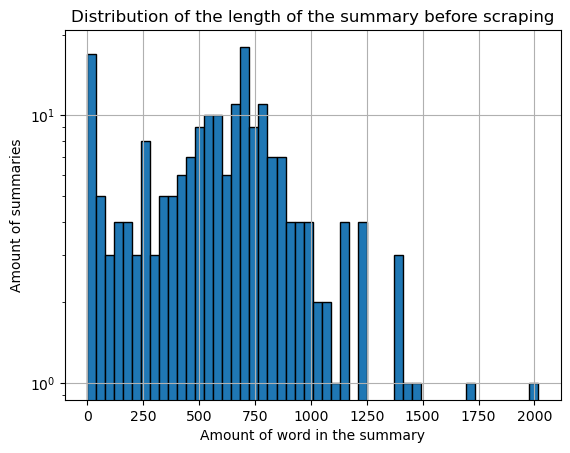

In [ ]:
# Plot the distribution of the length of the summaries before scraping
df_plot_length_unscraped = df_movie_unscraped['summary'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_plot_length_unscraped.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summaries')
plt.title('Distribution of the length of the summary before scraping')

Text(0.5, 1.0, 'Distribution of the length of the summary after scrapping')

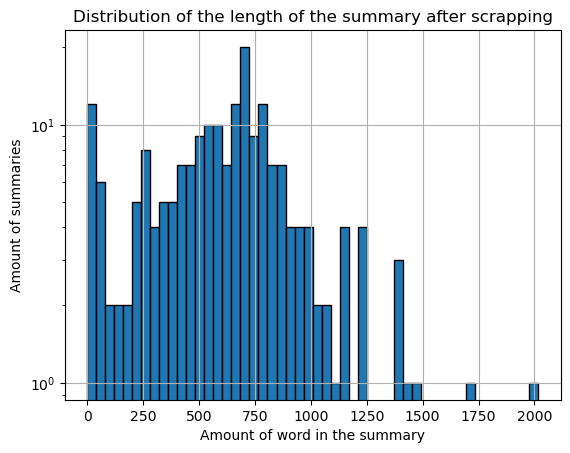

In [ ]:
# Plot the distribution of the length of the summaries after scraping
df_plot_length_scraped = df_movie['summary'].apply( lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_plot_length_scraped.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summaries')
plt.title('Distribution of the length of the summary after scrapping')

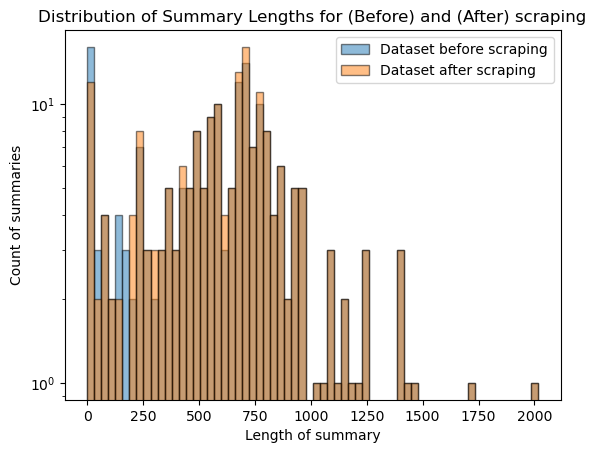

In [ ]:
# Calculate the common range for both datasets, before and after scraping
min_val = min(df_plot_length_unscraped.min(), df_plot_length_scraped.min())  
max_val = max(df_plot_length_unscraped.max(), df_plot_length_scraped.max()) 

# Define the bin edges based on the common range 
bin_edges = np.linspace(min_val, max_val, 65)  

# Plot histograms 
plt.hist(df_plot_length_unscraped, bins=bin_edges, edgecolor='black', alpha=0.5, label='Dataset before scraping')
plt.hist(df_plot_length_scraped, bins=bin_edges, edgecolor='black', alpha=0.5, label='Dataset after scraping')

# Set a logarithmic scale for the y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel('Length of summary')
plt.ylabel('Count of summaries')
plt.title('Distribution of Summary Lengths for (Before) and (After) scraping')
plt.legend()

# Show the plot
plt.show()

When comparing the two distributions of summary lengths, we observe that after scraping, there is an increase in the number of longer summaries, subsequently accompanied by a decrease in the number of shorter ones. This shift is further balanced by the fact that some previously missing summaries (NaN values) have now been populated.

In [ ]:
# Calculate word counts for unscraped datasets
df_movie_unscraped.loc[:, 'word_count'] = df_movie_unscraped['summary'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Calculate word counts for scraped dataset
df_movie.loc[:, 'word_count'] = df_movie['summary'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Calculate the differences in word counts 
word_count_diff = df_movie['word_count'] - df_movie_unscraped['word_count']

# Calculate the average and standard deviation of the differences
average_difference = word_count_diff.mean()
std_dev_difference = word_count_diff.std()

# Print the results
print(f"Average difference in word count: {average_difference:.2f}")
print(f"Standard deviation of the difference: {std_dev_difference:.2f}")


# Filter rows with 200 words or less
filtered_rows = df_movie_unscraped[df_movie_unscraped['word_count'] <= 200]

# Calculate percentage
percentage = (len(filtered_rows) / len(df_movie_unscraped)) * 100

print(f"Percentage of rows with summaries of 200 words or less: {percentage:.2f}%")

Average difference in word count: 19.90
Standard deviation of the difference: 98.21
Percentage of rows with summaries of 200 words or less: 16.50%


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_sample_unscraped.loc[:, 'word_count'] = df_movie_sample_unscraped['summary'].apply(

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_sample_for_scraping.loc[:, 'word_count'] = df_movie_sample_for_scraping['summary'].apply(



In [ ]:
# Count how many rows in scraped dataset are shorter than the corresponding rows in unscraped dataset
shorter_in_scraped_dataset = (word_count_diff < 0).sum()
longer_in_scraped_dataset = (word_count_diff > 0).sum()

max_longer = word_count_diff.max()
print(f"Max diff in word count: {max_longer:.2f}")

min_longer = word_count_diff.min()
print(f"Min diff in word count: {min_longer:.2f}")

total_rows = len(word_count_diff)

# Calculate the percentage
percentage_shorter_in_df2 = (shorter_in_scraped_dataset / total_rows) * 100
print(f"Percentage of rows where scraped dataset has fewer words than unscraped dataset: {percentage_shorter_in_df2:.2f}%")

percentage_longer_in_df2 = (longer_in_scraped_dataset / total_rows) * 100
print(f"Percentage of rows where scraped dataset has more words than unscraped dataset: {percentage_longer_in_df2:.2f}%")


Max diff in word count: 627.00
Min diff in word count: 0.00
Percentage of rows where scraped dataset has fewer words than unscraped dataset: 0.00%
Percentage of rows where scraped dataset has more words than unscraped dataset: 6.00%


Scraping to get Box office revenue using requests and Beautifulsoup

In [34]:
# Function to retrieve box office revenue from a movie's Wikipedia page
def get_box_office_from_wikipedia(row):
    title = row["Movie_name"]

    # Check if box office revenue is missing in the row
    if pd.isna(row["Movie_box_office_revenue"]): 

        if not isinstance(title, str) or title.strip() == '':
            return None
        
        # Check if the movie title corresponds to a valid Wikipedia page
        validity, title = is_film_Wiki_page(title)

        if validity:
            url = f'https://en.wikipedia.org/wiki/{title}'

            # Send a GET request to fetch the page content
            try:
                response = requests.get(url)
                response.raise_for_status()
            except requests.RequestException as e:
                print(f"Request failed for {title}: {e}")
                return None
            
            # Parse the response HTML using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            infobox = soup.find('table', {'class': 'infobox'})
            if infobox is None:
                return None
            
            box_office = None

            # Iterate through the rows in the infobox table to find box office information
            for row in infobox.find_all('tr'):
                header = row.find('th', {'scope': 'row'})
                if header and header.text.strip() in ['Box office', 'Revenue', 'Gross']:
                    box_office = row.find('td').text.strip()
                    box_office = re.sub(r'\[\d+\]', '', box_office).strip()
                    break
            
            return box_office
        return None
    else:
        return row["Movie_box_office_revenue"]

# Function to fetch box office data for multiple movie titles in parallel
def fetch_box_office_data(titles):
    results = {}
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_title = {executor.submit(get_box_office_from_wikipedia, title): title for title in titles}
        for future in as_completed(future_to_title):
            title = future_to_title[future]
            try:
                results[title] = future.result()
            except Exception as exc:
                print(f"Error fetching data for {title}: {exc}")
                results[title] = None
    return results


In [ ]:
# Apply box office scraping method to the sample dataset
df_movie["Movie_box_office_revenue"]= df_movie.apply(get_box_office_from_wikipedia, axis=1)

Request failed for Who Is Harry Kellerman and Why Is He Saying Those Terrible Things About Me?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who_Is_Harry_Kellerman_and_Why_Is_He_Saying_Those_Terrible_Things_About_Me
Request failed for What Do You Say to a Naked Lady?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What_Do_You_Say_to_a_Naked_Lady
Request failed for Who Do I Gotta Kill?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who_Do_I_Gotta_Kill
Request failed for If Footmen Tire You, What Will Horses Do?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/If_Footmen_Tire_You,_What_Will_Horses_Do
Request failed for What Time Is It There?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What_Time_Is_It_There
Request failed for Dude, Where's the Party?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Dude,_Where%27s_the_Party
Request failed for Now Where Did the 7th C

Sleeping for 5.0 seconds, 2024-11-24 10:32:38


Error in is_film_Wiki_page for [[Caltiki - Il mostro immortale]]: '[[Caltiki - Il mostro immortale]]' contains illegal char(s) '['


Sleeping for 5.0 seconds, 2024-11-24 10:49:18


Error in is_film_Wiki_page for Depeche Mode: The Videos 86>98: 'Depeche Mode: The Videos 86>98' contains illegal char(s) '>'
Request failed for Uuno Turhapuro &ndash; This Is My Life: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Uuno%20Turhapuro%20&ndash;%20This%20Is%20My%20Life


Sleeping for 5.0 seconds, 2024-11-24 11:08:56
Sleeping for 5.0 seconds, 2024-11-24 11:09:48


Error in is_film_Wiki_page for [[The Degraded]]: '[[The Degraded]]' contains illegal char(s) '['
Request failed for What Did You Do in the War, Daddy?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What_Did_You_Do_in_the_War,_Daddy
Request failed for Should Married Men Go Home?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Should_Married_Men_Go_Home
Request failed for What's a Nice Girl like You Doing in a Place like This?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What%27s_a_Nice_Girl_like_You_Doing_in_a_Place_like_This
Request failed for Who Was That Lady?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who_Was_That_Lady
Request failed for Do You Remember Laurie Zimmer?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Do_You_Remember_Laurie_Zimmer
Request failed for Is It College Yet?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Is_It_College_Yet
Request f

Sleeping for 5.0 seconds, 2024-11-24 12:29:06
Sleeping for 5.0 seconds, 2024-11-24 12:29:29


Request failed for Where Is the Friend's House?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Where_Is_the_Friend%27s_House
Request failed for Par où t'es rentré ? On t'a pas vu sortir: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Par%20o%C3%B9%20t'es%20rentr%C3%A9%20?%20On%20t'a%20pas%20vu%20sortir
Request failed for Where's Jack?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Where%27s_Jack
Request failed for Can Heironymus Merkin Ever Forget Mercy Humppe and Find True Happiness?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Can_Heironymus_Merkin_Ever_Forget_Mercy_Humppe_and_Find_True_Happiness
Request failed for What Will You Do When You Catch Me?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What_Will_You_Do_When_You_Catch_Me
Request failed for Keif al-Hal?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Keif_al-Hal
Request failed for The Goodies Rule – O

Sleeping for 5.0 seconds, 2024-11-24 13:14:32


Request failed for Hola, ¿estás sola?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Hola,_%C2%BFest%C3%A1s_sola
Request failed for Who Are the DeBolts? And Where Did They Get Nineteen Kids?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who%20Are%20the%20DeBolts?%20And%20Where%20Did%20They%20Get%20Nineteen%20Kids?
Request failed for ¿¡Revolución!?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/%C2%BF%C2%A1Revoluci%C3%B3n!
Request failed for Why Me, Sweetie?!: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Why%20Me,%20Sweetie?!
Request failed for Who Killed Mary What's 'Er Name?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who_Killed_Mary_What%27s_%27Er_Name
Request failed for Who's Got the Action?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who%27s_Got_the_Action


Sleeping for 5.0 seconds, 2024-11-24 14:20:24
Sleeping for 5.0 seconds, 2024-11-24 14:20:29


Request failed for Do You Like Hitchcock?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Do_You_Like_Hitchcock
Request failed for Häpy Endkö? Eli kuinka Uuno Turhapuro sai niin kauniin ja rikkaan vaimon: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/H%C3%A4py%20Endk%C3%B6?%20Eli%20kuinka%20Uuno%20Turhapuro%20sai%20niin%20kauniin%20ja%20rikkaan%20vaimon


Sleeping for 5.0 seconds, 2024-11-24 14:28:49


Request failed for Daddy's Dyin': Who's Got the Will?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Daddy%27s_Dyin%27:_Who%27s_Got_the_Will


Sleeping for 5.0 seconds, 2024-11-24 15:02:23


Request failed for Where's That Fire?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Where%27s_That_Fire
Request failed for I Wonder Who's Killing Her Now?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/I_Wonder_Who%27s_Killing_Her_Now
Request failed for So, What's Your Price?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/So,_What%27s_Your_Price
Request failed for How High Is Up?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/How_High_Is_Up


Sleeping for 5.0 seconds, 2024-11-24 15:58:08


Request failed for What's So Bad About Feeling Good?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What%27s_So_Bad_About_Feeling_Good
Request failed for Sinong Kapiling? Sinong Kasiping?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Sinong%20Kapiling?%20Sinong%20Kasiping?
Request failed for Who's Boss?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who%27s_Boss


Sleeping for 5.0 seconds, 2024-11-24 16:56:49
Sleeping for 5.0 seconds, 2024-11-24 16:56:54
Sleeping for 5.0 seconds, 2024-11-24 17:00:54
Sleeping for 5.0 seconds, 2024-11-24 17:06:08
Sleeping for 5.0 seconds, 2024-11-24 17:06:14
Sleeping for 5.0 seconds, 2024-11-24 17:07:45
Sleeping for 5.0 seconds, 2024-11-24 17:07:50
Sleeping for 5.0 seconds, 2024-11-24 17:08:21
Sleeping for 5.0 seconds, 2024-11-24 17:08:26


Request failed for What's the World Coming To?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What%27s_the_World_Coming_To


Sleeping for 5.0 seconds, 2024-11-24 17:29:42
Sleeping for 5.0 seconds, 2024-11-24 17:29:47
Sleeping for 5.0 seconds, 2024-11-24 17:31:40
Sleeping for 5.1 seconds, 2024-11-24 17:31:46


Request failed for Ganito Kami Noon... Paano Kayo Ngayon?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Ganito_Kami_Noon..._Paano_Kayo_Ngayon
Request failed for Where Are You My Love, That I Cannot Find You?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Where_Are_You_My_Love,_That_I_Cannot_Find_You
Request failed for Where Is Winky's Horse?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Where_Is_Winky%27s_Horse
Request failed for Who Killed Dr Bogle and Mrs Chandler?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Who_Killed_Dr_Bogle_and_Mrs_Chandler
Request failed for What's the Matador?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What%27s_the_Matador
Request failed for Why Has Bodhi-Dharma Left for the East?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Why_Has_Bodhi-Dharma_Left_for_the_East
Request failed for Where Are the Children?: 404 Client Error: No

Sleeping for 5.0 seconds, 2024-11-24 19:46:40


Request failed for What's the Matter with Helen?: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/What%27s_the_Matter_with_Helen


For a sample of 2000 movies, we count 25 minutes of running time

In [ ]:
print("The percentage of missing values in the Box office revenue category before scraping is:")
print(df_movie_unscraped["Movie_box_office_revenue"].isna().sum() / len(df_movie_unscraped) * 100)
print("The percent age of missing values in the Box office revenue category after scraping is:")
print(df_movie["Movie_box_office_revenue"].isna().sum() / len(df_movie)*100)

The percentage of missing values in the Box office revenue category before scraping is:
49.65
The percent age of missing values in the Box office revenue category after scraping is:
36.4


### Plot the results

Plot the percentage of missing values in the Box office revenue category, for a sample of 2000 values, before and after scraping

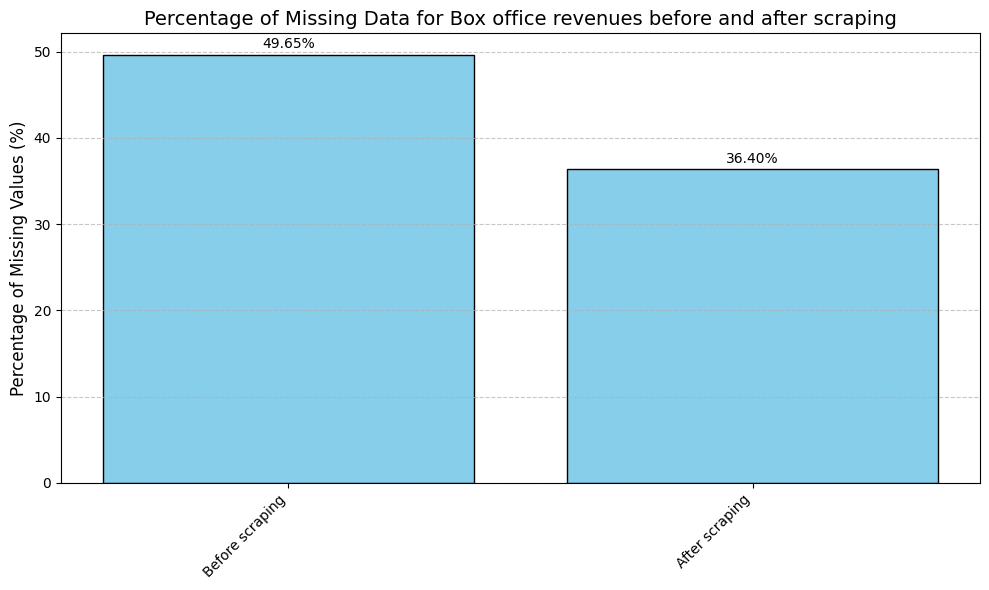

In [ ]:
# Calculate the percentage of missing values in the Box office revenue category, for a sample of 2000 values of the dataset
missing_values_before_scraping = df_movie_unscraped["Movie_box_office_revenue"].isna().sum() / len(df_movie_unscraped) * 100
missing_values_after_scraping = df_movie["Movie_box_office_revenue"].isna().sum() / len(df_movie) * 100

# Plot the filtered missing values as a bar chart
plt.figure(figsize=(10, 6))

plt.bar(['Before scraping', 'After scraping'], [missing_values_before_scraping, missing_values_after_scraping],color='skyblue', edgecolor='black')


plt.title('Percentage of Missing Data for Box office revenues before and after scraping', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the percentage value above each bar
for i, value in enumerate([missing_values_before_scraping, missing_values_after_scraping]):
    plt.text(i, value + 0.4, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

We observe that after scraping, on our sample of 2000 elements, we reduce the number of missing values in the Box office revenue category by more than 25%.